In [1]:
from pybaseball import batting_stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = batting_stats(2024)
features = ["OBP","SLG","WAR","BB%","K%","BABIP","Barrel%"]
df = data[features].dropna()

We will be considering the following metrics from the 2024 batting stats

1. **OBP (On-Base Percentage)** – a player's ability to reach base.
2. **SLG (Slugging Percentage)** – a measure of how often and how hard a player hits.
3. **WAR (Wins Above Replacement)** – how many wins a player contributes to their team.
4. **BB% (Walk Rate)** – a players plate discipline -- their ability not to swing at wild pitches.
5. **K% (Strikeout Rate)** – how often the player is struck out.
6. **BABIP (Batting Average on Balls in Play)** – batting average on hits (excluding home runs) used to measure performance without luck.
7. **Barrel% (Barrel Rate)** – measures how often a player gets an optimal hit (high exit velocity + good launch angle).

These metrics provide a wide array of components that batting influences. We will use PCA to determine outlying players.

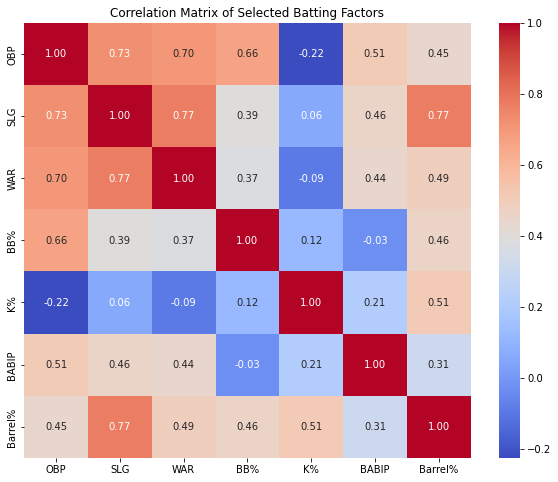

In [3]:
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Selected Batting Factors")
plt.show()

### PCA
The goal of PCA is to reduce the number of variables in a dataset while preserving its essential information. Intuitively, just from looking at our correleation matrix, we could expect OBP, SLG, and WAR to be grouped together into one prncipal component just due to their high correleation. However, how much of our data would this one component cover? And what else could we group together to cover the rest?

### Steps
1. **Standardize the Data:** 
We start by normalizing each feature so they have the same scale.
 $$z = \frac{x - \bar{x}}{\text{std}(x)}$$
 
We do this for every column to create the $m\times n$ matrix $A$. 

2. **Compute the Correlation Matrix:**

$$
S = \frac{1}{n-1}AA^T
$$

This matrix shows how features relate to each other. Positive values mean features increase together; negative values mean one increases while the other decreases. The diagonal vaues are the variance of that feature. This matrix is symmetric and has size $m \times m$. Its columns are of the same size as the columns of $A$.



3. **Find the Key Directions (Eigenvectors & Eigenvalues):**  

We can express $A$ as

$$
A = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^{T}, 
$$


These eigenvectors are columns of the matrix $U$ in the singular value decomposition of $A$, up to the factor $n-1$. Further, we denote the eigenvalues by $\sigma_{i}^{2}$. This is equivalent to the **Singular Value Decomposition** of our shifted training set matrix $A$. We can calculate this with `np.linalg.svd`.





4. **Identify Principal Components:** 

We arrange the eigenvalues decreasing order. The first principal component $PC_1$ is in the direction of the 1st eigenvector, the second principal component $PC_2$ is in the direction of the 2nd eigenvector, and so on. The entries of each $PC_i$ are called **loading scores** and they tell us how the $PC_i$ is a linear combination of features.

5. **Reduce Dimensionality:** 

We project data points (which are the columns of $A$) onto the selected principal components (given by $S$). To project the data contained in $A$ onto the first two principle component axis for example, we compute $A [PC_1 PC_2]$.

---

All of this is encapsulated in the SKlearn PCA class, which we will use for simplicity.


In [4]:
scaler = StandardScaler()
batting_scaled = scaler.fit_transform(df)
pca = PCA(n_components=3)
principal_components = pca.fit_transform(batting_scaled)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2','PC3'])

In [5]:
explained_variance_ratio = pca.explained_variance_ratio_
print(explained_variance_ratio)
print(sum(explained_variance_ratio))

[0.51567566 0.19957164 0.1516308 ]
0.8668781051630614


We are using 3 components because they explain 86% of the variance. Using only two would only capture around 70% while using more would get hard to visualize and cluster (due to the curse of dimensionality).

In [6]:
loading_score = pd.DataFrame(pca.components_.T, index=df.columns[:len(features)], columns=['PC1', 'PC2','PC3'])
print(loading_score)

              PC1       PC2       PC3
OBP      0.455983  0.330614 -0.054212
SLG      0.481283  0.014544  0.078837
WAR      0.437262  0.211678  0.134845
BB%      0.324526  0.033179 -0.684629
K%       0.076709 -0.812969 -0.018235
BABIP    0.298685 -0.088458  0.696185
Barrel%  0.410894 -0.419322 -0.137619


###  Feature Contributions
- **PC1:** Reflects **power and efficiency** through positive correlation with SLG, OBP, WAR, and Barrel%.
- **PC2:** Reflects **amount a player gets on base** by strong negative correlation with strikeout percentage (as well as barrel percantage for some reason) and some positive correlation with OBP 
- **PC3:** how **lucky a player is when he gets on base** due to high positive correlation with BABIP and negative correlation with BB%.

We will use DBSCAN to find some outlier players in these three categories.

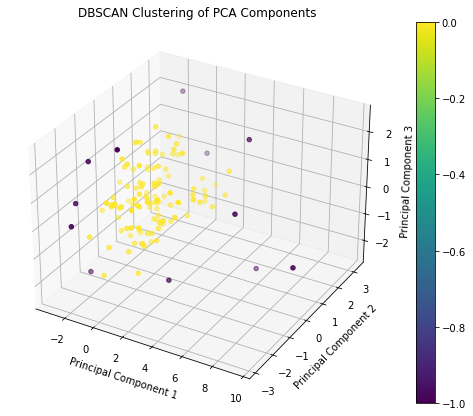

In [7]:
from sklearn.cluster import DBSCAN
from mpl_toolkits.mplot3d import Axes3D

# Apply DBSCAN clustering on PCA-reduced data
dbscan = DBSCAN(eps=1.25, min_samples=5)  # Tune these values as needed
pca_df['Cluster'] = dbscan.fit_predict(pca_df[['PC1', 'PC2', 'PC3']])

# 3D Scatter Plot of DBSCAN clusters
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Color clusters; Noise points are -1
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['Cluster'], cmap='viridis', marker='o')

# Labels
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('DBSCAN Clustering of PCA Components')

plt.colorbar(scatter)
plt.show()

Given our current settings for $\varepsilon$ and $k$, we get 12 outliers. We will inspect them.

In [8]:
pca_df.Cluster.value_counts()

 0    117
-1     12
Name: Cluster, dtype: int64

In [9]:
final = pd.merge(data,pca_df, left_index = True, right_index = True)
final[final.Cluster == -1][["Name"]+features+["PC1","PC2","PC3"]]

,Name,OBP,SLG,WAR,BB%,K%,BABIP,Barrel%,PC1,PC2,PC3
0,Aaron Judge,0.458,0.701,11.2,0.189,0.243,0.367,0.269,9.494775,-0.050649,-1.015861
3,Bobby Witt Jr.,0.389,0.588,10.4,0.080,0.150,0.354,0.143,5.600992,1.266885,-2.463334
1,Shohei Ohtani,0.390,0.646,9.1,0.111,0.222,0.336,0.214,4.536018,1.685371,1.877999
2,Juan Soto,0.419,0.569,8.1,0.181,0.167,0.298,0.197,5.739543,-0.156474,0.380591
28,Anthony Santander,0.308,0.506,3.3,0.087,0.194,0.225,0.117,0.100769,2.995749,0.069179
49,Brendan Donovan,0.342,0.417,3.2,0.072,0.124,0.300,0.055,2.603321,-1.262883,-1.886637
39,Tyler Stephenson,0.338,0.444,3.0,0.093,0.227,0.307,0.091,-0.234970,-1.681981,2.574447
113,Bryson Stott,0.315,0.356,1.9,0.093,0.163,0.275,0.036,-2.350097,-1.608887,1.818031
109,Colt Keith,0.309,0.380,1.8,0.065,0.198,0.306,0.056,-1.852013,3.189072,1.998348
103,Lane Thomas,0.309,0.400,1.3,0.083,0.259,0.298,0.074,-1.914291,-2.871080,0.262701


### Interpreting these Results
Being an outlier in our DBSCAN means that a player has a distincitve combination of their principal components.Some of these make sense, like Aaron Judge, Bobby Wilt Jr, Sohei Ohtani, and Juan Soto who are very valuable players and have elite WARs. Others like Maikel Garcia are weak all around and thus are an outlier for that reason. And the rest are outliers because they are distincitively good (or bad) in one or two of the principal components, thus making them in some way a unique player.